# Section 1: Import Libraries and Load Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Load data
train_data_path = 'train.csv'
test_data_path = 'test.csv'
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# Display initial data structure
train_df.head(), test_df.head()

(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

# Section 2: Exploratory Data Analysis

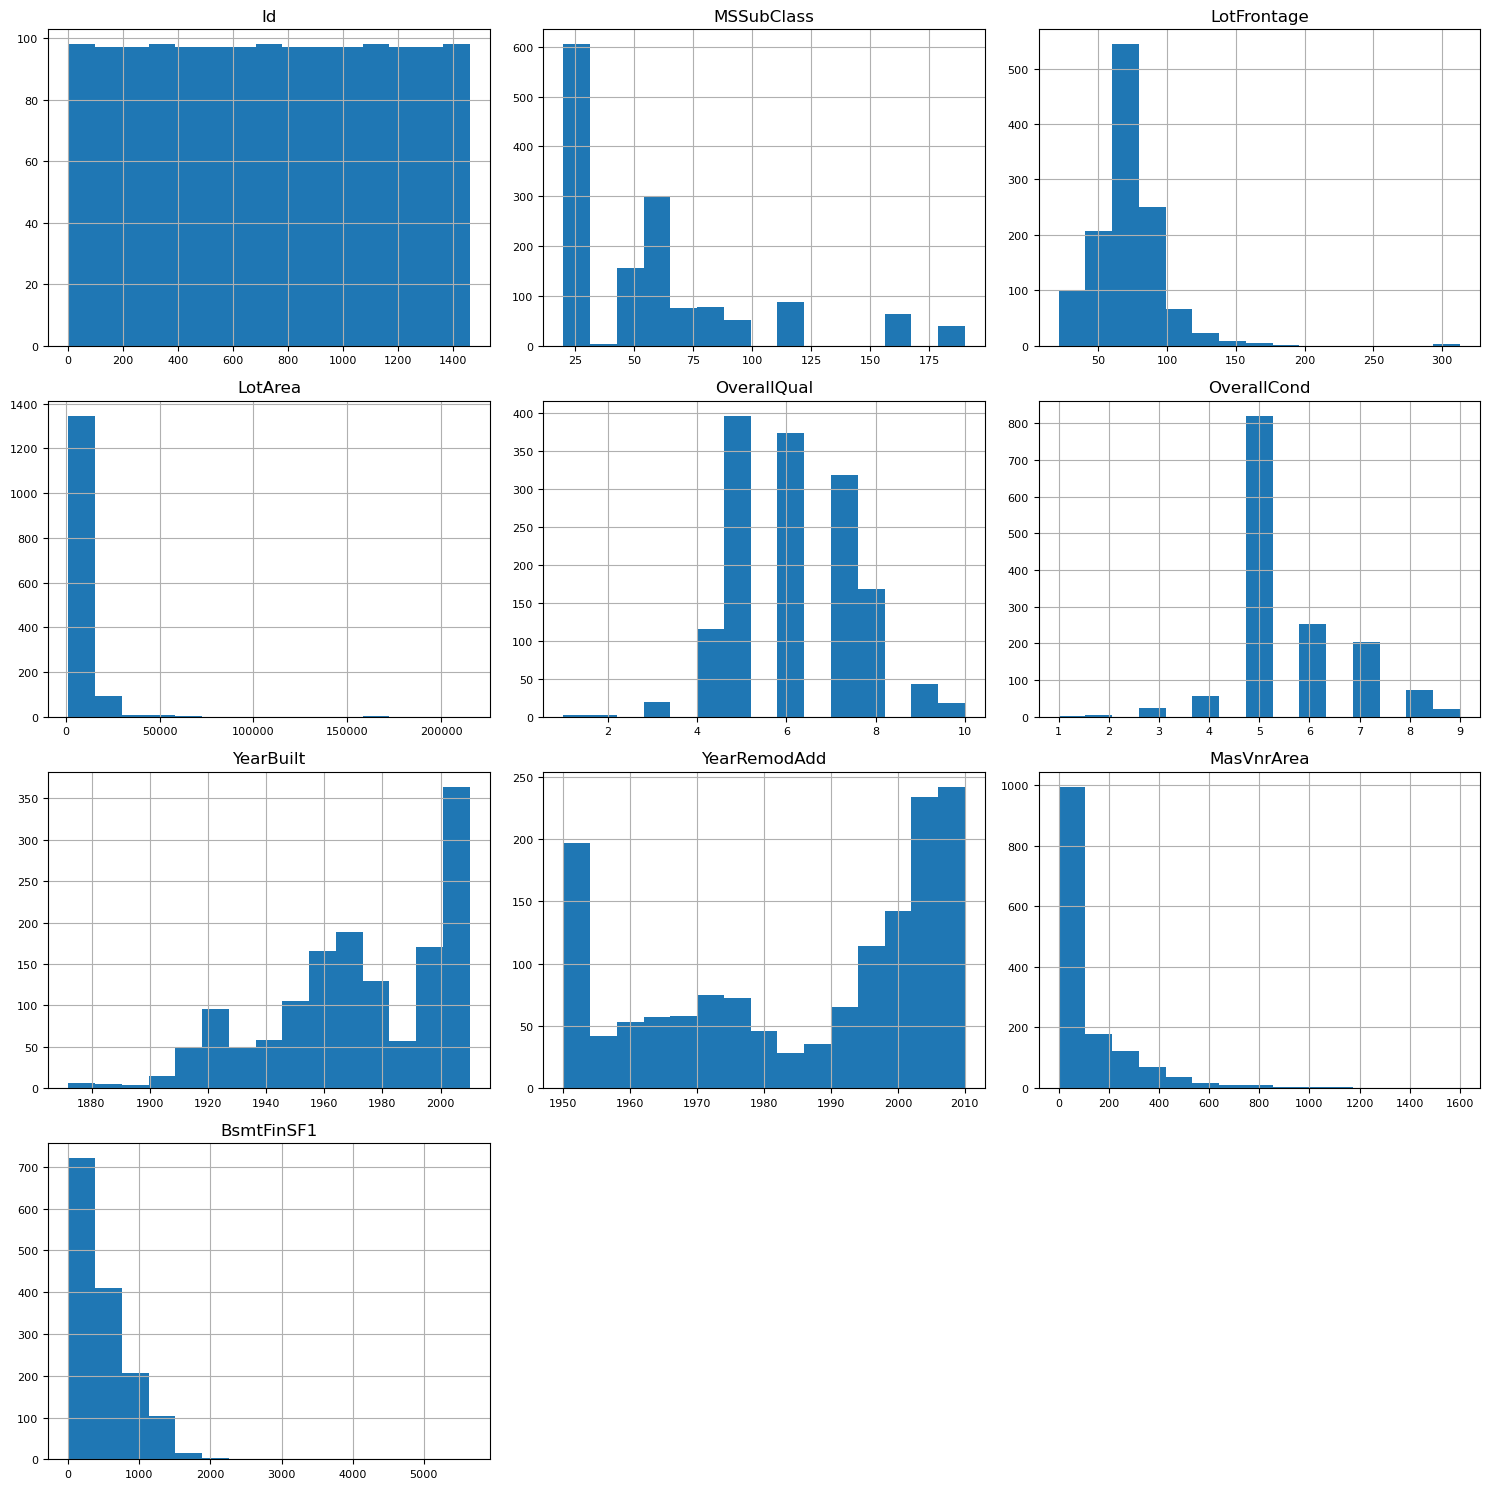

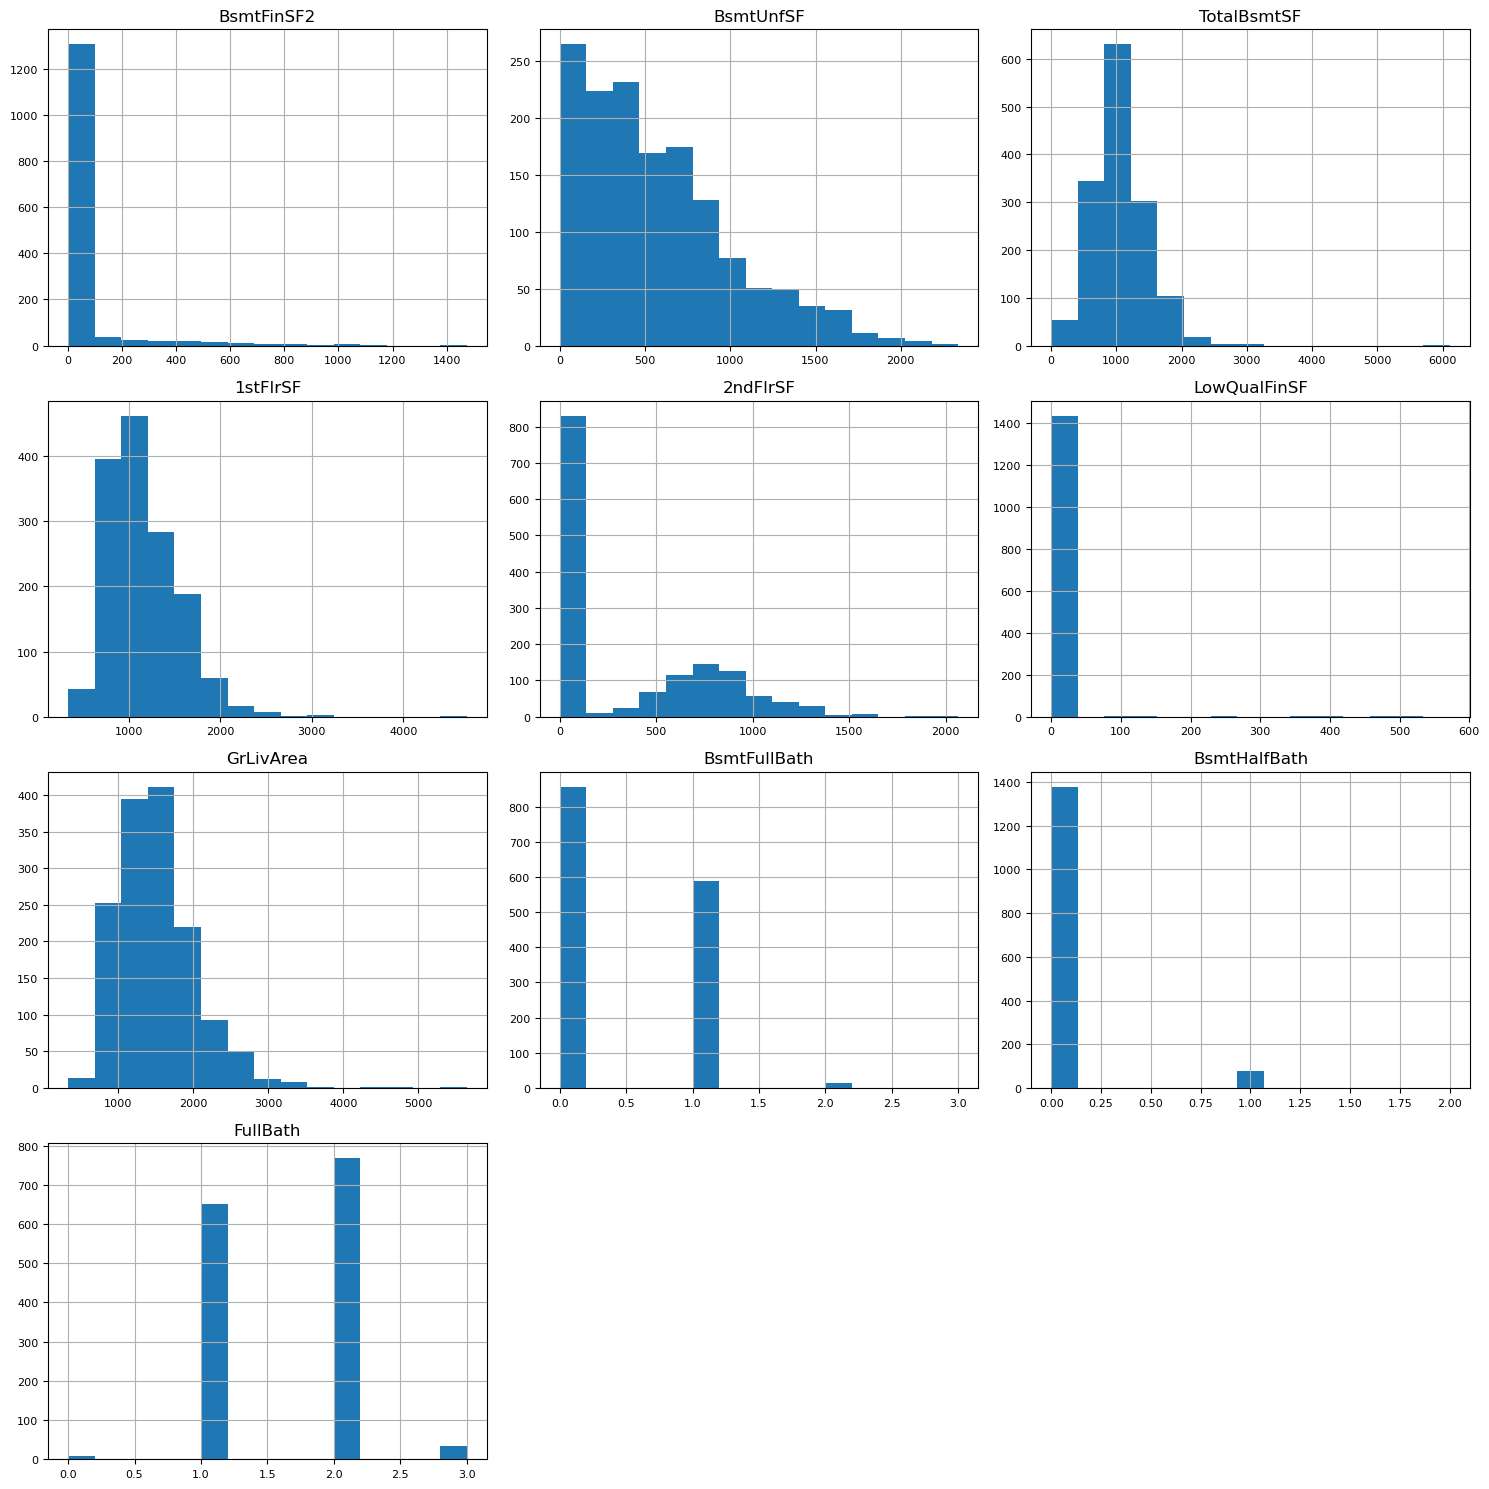

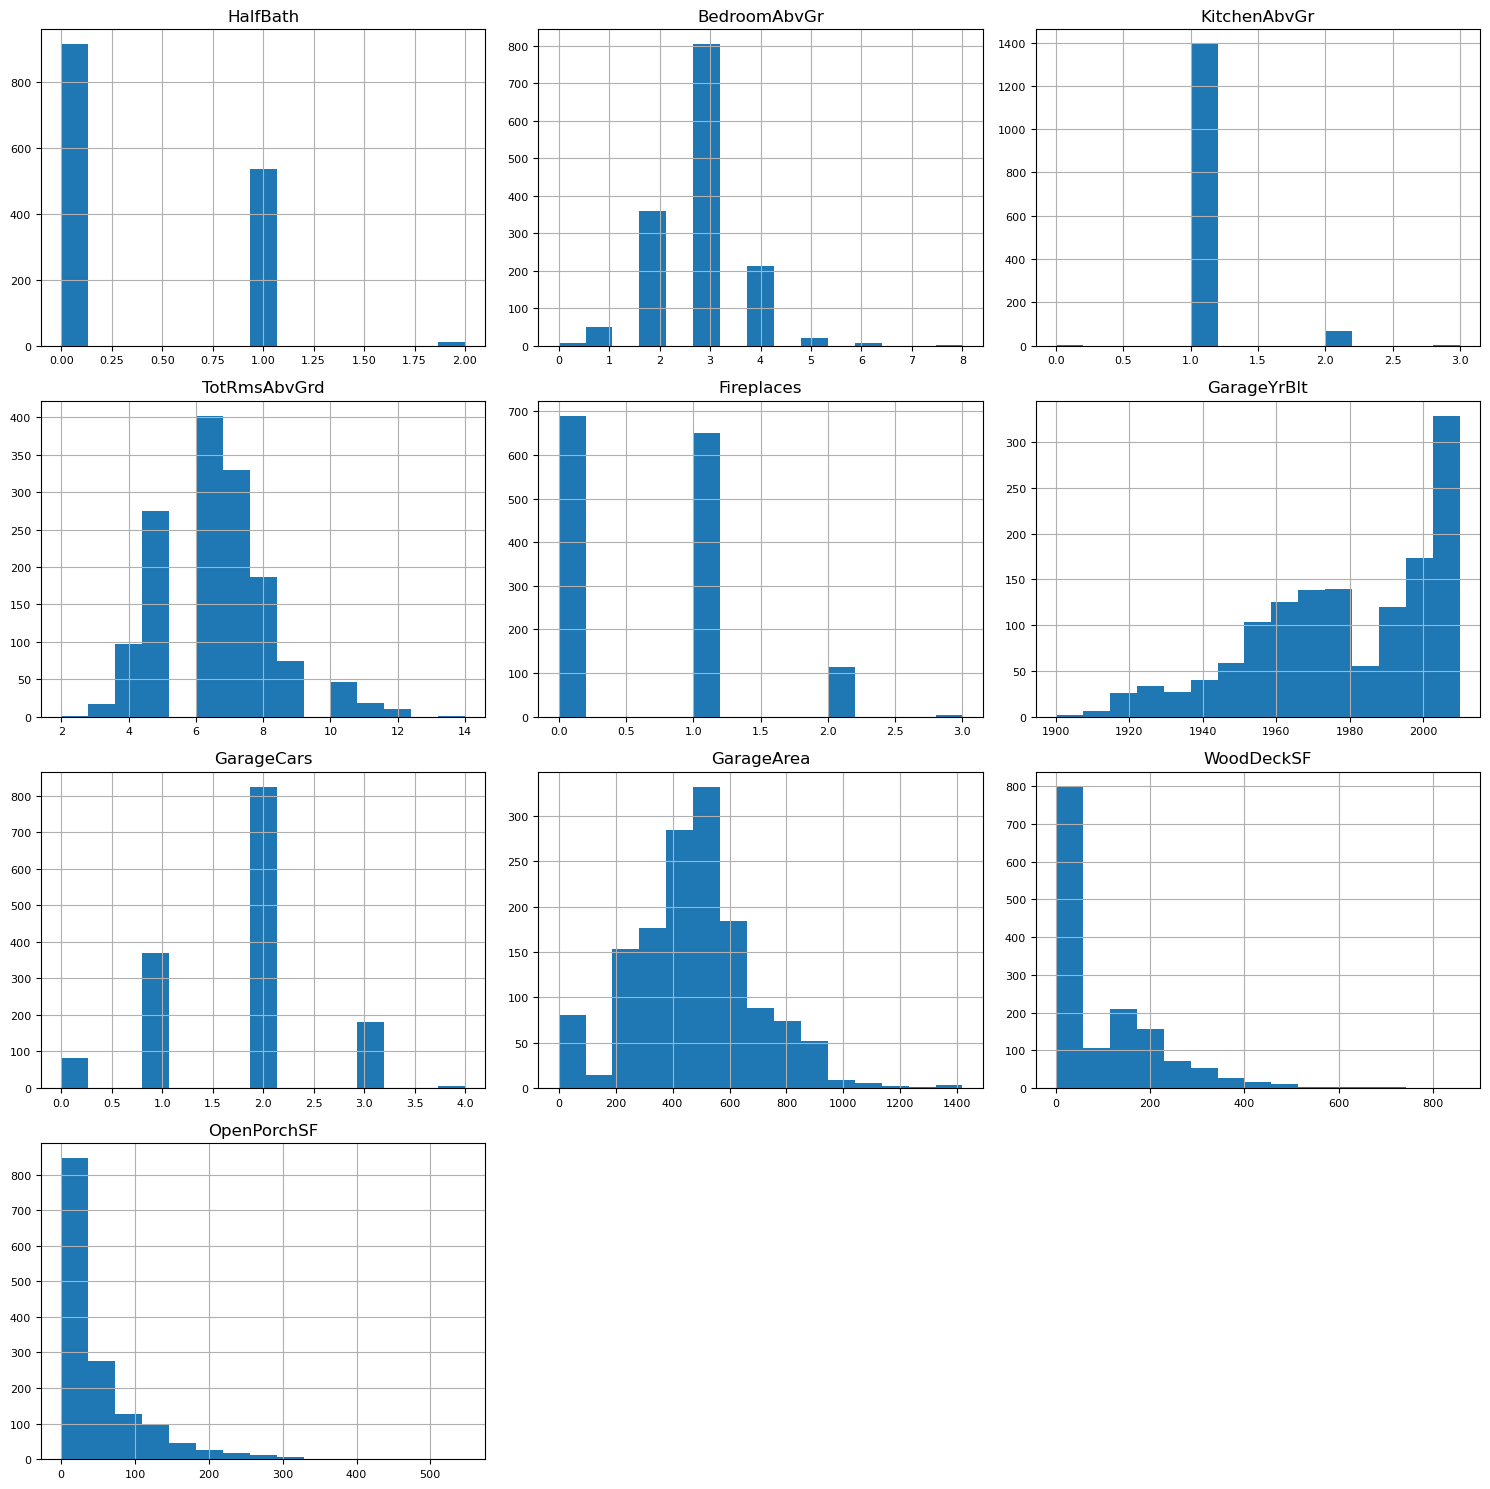

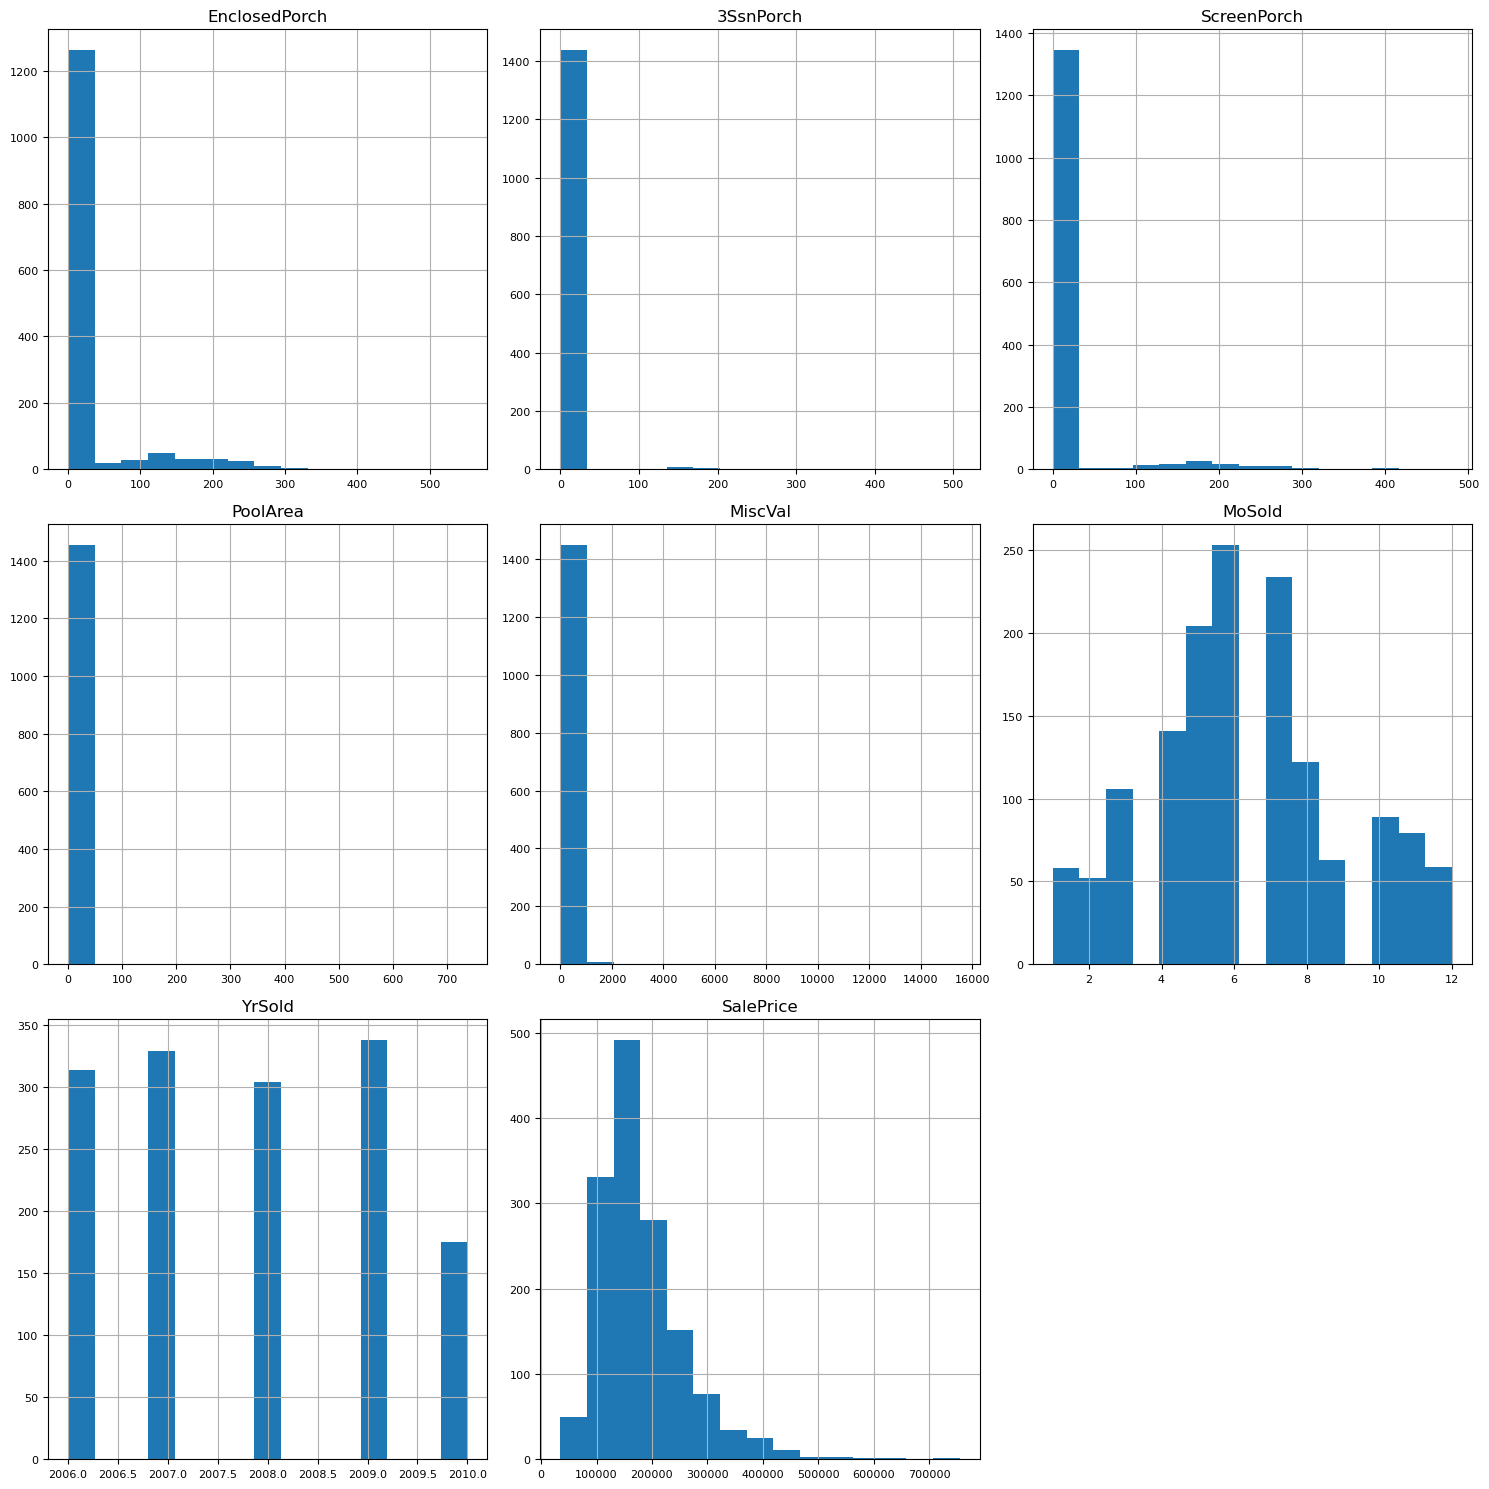

In [2]:
# Define number of features per figure for visualization
features_per_figure = 10
num_features = train_df.select_dtypes(include=[np.number]).columns
total_features = len(num_features)
total_figures = (total_features + features_per_figure - 1) // features_per_figure

# Generate histogram figures
for i in range(total_figures):
    start_idx = i * features_per_figure
    end_idx = min(start_idx + features_per_figure, total_features)
    subset_features = num_features[start_idx:end_idx]
    train_df[subset_features].hist(bins=15, figsize=(15, 15), xlabelsize=8, ylabelsize=8)
    plt.tight_layout()
    plt.show()


# Section 3: Correlation Analysis

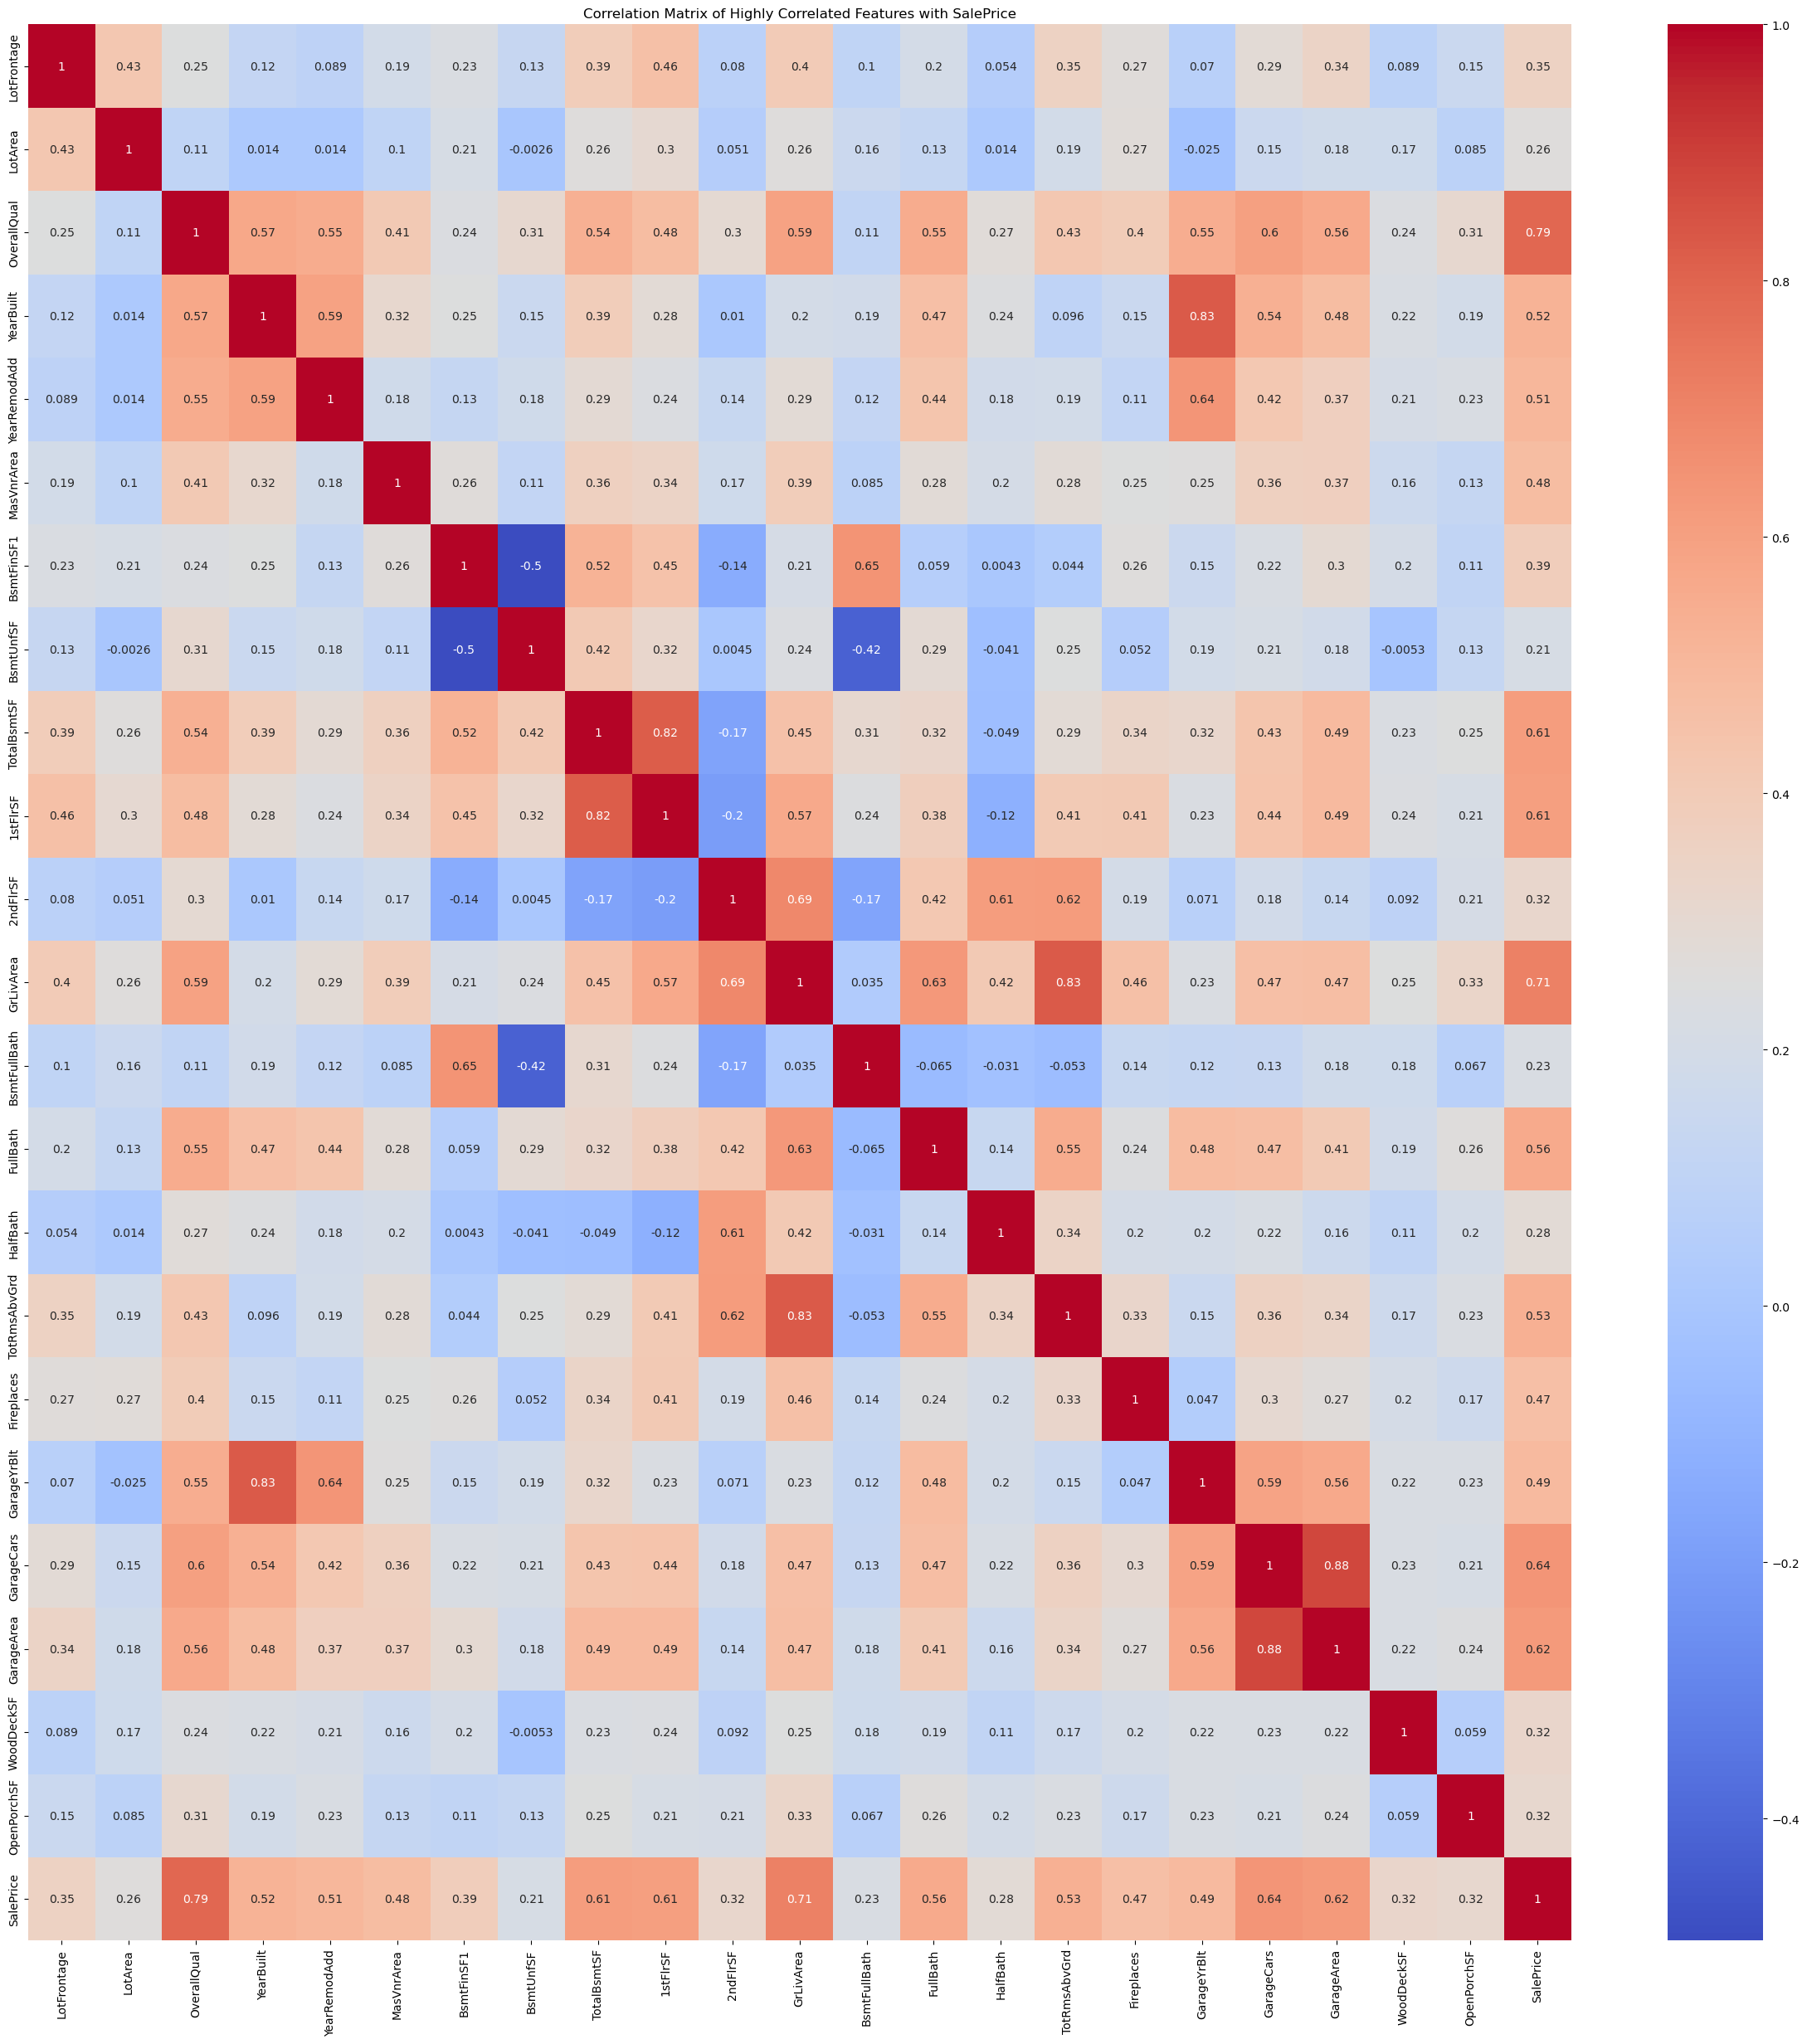

In [3]:
# Numerical data correlation with 'SalePrice'
numerical_train_df = train_df.select_dtypes(include=['int64', 'float64'])
saleprice_corr = numerical_train_df.corr()['SalePrice'].sort_values(ascending=False)
saleprice_corr = saleprice_corr.drop('SalePrice')
saleprice_corr

# Correlation matrix for highly correlated features
correlation = numerical_train_df.corr()
high_corr_features = correlation.index[abs(correlation['SalePrice']) > 0.2]
plt.figure(figsize=(30, 30))
sns.heatmap(numerical_train_df[high_corr_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Highly Correlated Features with SalePrice")
plt.show()

# Section 4: Data Preprocessing

In [7]:
# Section 4: Data Preprocessing

# Handling Missing Data
# Identifying missing values in each column
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_percent = (missing_values / train_df.shape[0]) * 100

# Display missing values and their percentage
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percent': missing_percent})
print(missing_df)

# Strategy for handling missing data:
# 1. For numerical features, impute missing values with the median.
# 2. For categorical features, impute missing values with the mode.
# 3. If a feature has more than a certain threshold of missing values (e.g., 50%), consider dropping it.

# Imputing or Dropping Missing Data
for column in missing_values.index:
    if missing_percent[column] > 50:
        # Drop columns with more than 50% missing data
        train_df.drop(columns=[column], inplace=True)
    else:
        if train_df[column].dtype == 'object':
            # Impute categorical features with mode
            train_df[column].fillna(train_df[column].mode()[0], inplace=True)
        else:
            # Impute numerical features with median
            train_df[column].fillna(train_df[column].median(), inplace=True)

# Feature Engineering and Categorical Encoding
train_df['TotalSqFt'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['TotalSqFt'] = np.log1p(train_df['TotalSqFt'])
train_df['LotArea'] = np.log1p(train_df['LotArea'])
categorical_cols = train_df.select_dtypes(include=['object']).columns
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)

# Note: Ensure that similar preprocessing steps are applied to any test or validation dataset before model training or prediction.



Empty DataFrame
Columns: [Missing Values, Percent]
Index: []


# Section 5: Outlier Detection and Removal


In [8]:

# Outlier Detection and Individual Removal
# Using the Interquartile Range (IQR) method to detect and individually remove outliers

# Define a function to remove individual outliers using IQR
def remove_individual_outliers(df, columns):
    for column in columns:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column], 75)
        
        # IQR
        IQR = Q3 - Q1
        
        # Outlier step
        outlier_step = 1.5 * IQR
        
        # Filtering the outliers from the dataframe
        df = df[(df[column] >= Q1 - outlier_step) & (df[column] <= Q3 + outlier_step)]
    
    return df

# Selecting numerical columns for outlier removal
numerical_cols = train_df.select_dtypes(include=[np.number]).columns

# Removing individual outliers from the dataset
train_df = remove_individual_outliers(train_df, numerical_cols)
train_df
# Note: Individual outlier removal can be a better choice compared to removing entire features, 
# especially in datasets with limited data. However, it's still crucial to consider the context 
# and nature of your data when determining outlier thresholds.


Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0        1          60         65.0  1.195975            7            5   
2        3          60         68.0  1.204436            7            5   
6        7          20         75.0  1.201238            8            5   
10      11          20         70.0  1.204307            5            5   
13      14          20         91.0  1.202845            7            5   
...    ...         ...          ...       ...          ...          ...   
1436  1437          20         60.0  1.197866            4            6   
1444  1445          20         63.0  1.196153            7            5   
1447  1448          60         80.0  1.200992            8            5   
1451  1452          20         78.0  1.198721            8            5   
1455  1456          60         62.0  1.194005            6            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  \
0          2003          2003       196.0         706  ...           False   
2          2001          2002       162.0         486  ...           False   
6          2004          2005       186.0        1369  ...           False   
10         1965          1965         0.0         906  ...           False   
13         2006          2007       306.0           0  ...           False   
...         ...           ...         ...         ...  ...             ...   
1436       1971          1971         0.0         616  ...           False   
1444       2004          2004       106.0           0  ...           False   
1447       1995          1996       438.0        1079  ...           False   
1451       2008          2009       194.0           0  ...           False   
1455       1999          2000         0.0           0  ...           False   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0              False         False         False         True   
2              False         False         False         True   
6              False         False         False         True   
10             False         False         False         True   
13             False          True         False        False   
...              ...           ...           ...          ...   
1436           False         False         False         True   
1444           False         False         False         True   
1447           False         False         False         True   
1451           False          True         False        False   
1455           False         False         False         True   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                     False                 False                 False   
2                     False                 False                 False   
6                     False                 False                 False   
10                    False                 False                 False   
13                    False                 False                 False   
...                     ...                   ...                   ...   
1436                  False                 False                 False   
1444                  False                 False                 False   
1447                  False                 False                 False   
1451                  False                 False                 False   
1455                  False                 False                 False   

      SaleCondition_Normal  SaleCondition_Partial  
0                     True                  False  
2                     True                  False  
6                     True                  False  
10                    True                  False  
13                   False                   True  
...                    ...                    ...  
1436                  True                  False  
1444                  True                  False  
1447                

In [ ]:
# Section 6: Multicollinearity Reduction and Feature Scaling

In [10]:
# Define function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Iteratively remove features with high VIF
vif_threshold = 12
numerical_features = train_df.select_dtypes(include=[np.number])
while True:
    vif_data = calculate_vif(numerical_features)
    max_vif = vif_data['VIF'].max()
    if max_vif > vif_threshold:
        feature_to_drop = vif_data[vif_data['VIF'] == max_vif]['feature'].values[0]
        numerical_features.drop(columns=[feature_to_drop], inplace=True)
        print(f"Dropping: {feature_to_drop} with VIF: {max_vif}")
    else:
        break

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features.columns)
scaled_df

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in dou

Dropping: YearBuilt with VIF: inf
Dropping: BsmtFinSF1 with VIF: inf
Dropping: 1stFlrSF with VIF: inf
Dropping: TotalSqFt with VIF: 145.975509000701
Dropping: HouseAge with VIF: 25.223678815281286
Dropping: 2ndFlrSF with VIF: 14.773410017279085


/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0   -1.732207    0.859975    -0.571822 -0.622777     0.645951    -0.534709   
1   -1.727480    0.859975    -0.305671  0.673657     0.645951    -0.534709   
2   -1.718025   -0.936175     0.315349  0.183593     1.564762    -0.534709   
3   -1.708571   -0.936175    -0.128237  0.653838    -1.191669    -0.534709   
4   -1.701480   -0.936175     1.734823  0.429869     0.645951    -0.534709   
..        ...         ...          ...       ...          ...          ...   
325  1.661915   -0.936175    -1.015408 -0.333044    -2.110479     0.948097   
326  1.680824   -0.936175    -0.749256 -0.595569     0.645951    -0.534709   
327  1.687915    0.859975     0.758935  0.145848     1.564762    -0.534709   
328  1.697369   -0.936175     0.581500 -0.201974     1.564762    -0.534709   
329  1.706823    0.859975    -0.837973 -0.924637    -0.272859    -0.534709   

     YearRemodAdd  MasVnrArea  BsmtFinSF2  BsmtUnfSF  ...  WoodDeckSF  \
0        0.721827    1.175007         0.0  -1.092570  ...   -0.897286   
1        0.667231    0.847424         0.0  -0.447725  ...   -0.897286   
2        0.831019    1.078660         0.0  -0.713383  ...    1.599957   
3       -1.352826   -0.713413         0.0  -1.128900  ...   -0.897286   
4        0.940212    2.234835         0.0   1.959094  ...    0.669611   
..            ...         ...         ...        ...  ...         ...   
325     -1.025249   -0.713413         0.0  -0.870053  ...   -0.897286   
326      0.776423    0.307876         0.0   1.795612  ...    0.982991   
327      0.339654    3.506629         0.0  -1.113006  ...   -0.897286   
328      1.049404    1.155738         0.0   2.138470  ...   -0.897286   
329      0.558039   -0.713413         0.0   0.730708  ...   -0.897286   

     OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0       0.410304            0.0        0.0          0.0       0.0      0.0   
1      -0.021994            0.0        0.0          0.0       0.0      0.0   
2       0.319294            0.0        0.0          0.0       0.0      0.0   
3      -0.977600            0.0        0.0          0.0       0.0      0.0   
4      -0.226767            0.0        0.0          0.0       0.0      0.0   
..           ...            ...        ...          ...       ...      ...   
325    -0.977600            0.0        0.0          0.0       0.0      0.0   
326     0.387551            0.0        0.0          0.0       0.0      0.0   
327     0.501314            0.0        0.0          0.0       0.0      0.0   
328    -0.158509            0.0        0.0          0.0       0.0      0.0   
329    -0.067499            0.0        0.0          0.0       0.0      0.0   

       MoSold    YrSold  SalePrice  
0   -1.674402  0.177030   0.600621  
1    1.022856  0.177030   0.930161  
2    0.637534 -0.591652   2.764603  
3   -1.674402  0.177030  -1.134959  
4    0.637534 -0.591652   2.160446  
..        ...       ...        ...  
325 -0.518434 -0.591652  -1.332683  
326  1.793502 -0.591652  -0.034294  
327  2.178824 -0.591652   1.292656  
328 -0.518434  0.945711   2.327193  
329  0.637534 -0.591652  -0.135353  

[330 rows x 34 columns]

In [11]:
# Define the path for saving the file
output_file_path = 'clean_data.csv'

# Save the submission DataFrame to a CSV file
scaled_df.to_csv(output_file_path, index=False)

output_file_path

'clean_data.csv'

# 7. Model selection

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Define a custom scorer for RMSE of log values
def rmse_log(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred)))

rmse_log_scorer = make_scorer(rmse_log, greater_is_better=False)


In [16]:
# Splitting data into training and testing sets
X = scaled_df.drop('SalePrice', axis=1)
y = scaled_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Random Forest parameters
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model initialization and GridSearchCV setup for Random Forest
rf_model = RandomForestRegressor()
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring=rmse_log_scorer, n_jobs=-1)

# Perform grid search and fit model
print("Fitting Random Forest...")
rf_grid.fit(X_train, y_train)

# Best parameters and best score for Random Forest
print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best score for Random Forest:", rf_grid.best_score_)


Fitting Random Forest...


/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/

    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 474, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py", line 11, in rmse_log
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 474, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py", line 11, in rmse_log
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 474, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/py

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: nan


In [17]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model initialization and GridSearchCV setup for Gradient Boosting
gb_model = GradientBoostingRegressor()
gb_grid = GridSearchCV(gb_model, gb_params, cv=5, scoring=rmse_log_scorer, n_jobs=-1)

# Perform grid search and fit model
print("Fitting Gradient Boosting...")
gb_grid.fit(X_train, y_train)

# Best parameters and best score for Gradient Boosting
print("Best parameters for Gradient Boosting:", gb_grid.best_params_)
print("Best score for Gradient Boosting:", gb_grid.best_score_)


Fitting Gradient Boosting...


/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py", line 11, in rmse_log
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 474, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 474, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 12

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/py

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/py

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py", line 11, in rmse_log
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 474, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/py

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

    y_type, y_true, y_pred, multioutput = _check_reg_targets(
                                          ^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/pytho

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 100, in _check_reg_targets
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packa

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:8

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.

  warnings.warn(
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/py

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y8/qf4y__nx4_qdp9d81sgjvfjm0000gn/T/ipykernel_8705/1724053070.py:11: RuntimeWarning: invalid value encountered in log
/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/anaconda3/envs/tenserflow/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, 

Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Gradient Boosting: nan


In [ ]:
# Decision Tree parameters
dt_params = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model initialization and GridSearchCV setup for Decision Tree
dt_model = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring=rmse_log_scorer, n_jobs=-1)

# Perform grid search and fit model
print("Fitting Decision Tree...")
dt_grid.fit(X_train, y_train)

# Best parameters and best score for Decision Tree
print("Best parameters for Decision Tree:", dt_grid.best_params_)
print("Best score for Decision Tree:", dt_grid.best_score_)
